3![image info](https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/images/banner_1.png)

# Taller: Análisis de sentimientos y técnicas de NLP

En este taller podrán poner en práctica sus conocimientos sobre las diferentes técnicas para el procesamiento de lenguaje natural. El taller está constituido por 5 puntos, en los cuales deberan seguir las intrucciones de cada numeral para su desarrollo.

## Datos predicción sentimientos de viajeros en Twitter

En este taller se usará el conjunto de datos de sentimientos sobre distintas aerolíneas de EE.UU. provenientes de Twitter. Cada observación contiene si el sentimiento de los tweets es positivo, neutral o negativo teniendo en cuenta distintas variables como aerolínea y las razones de los sentimientos negativos (como "retraso en el vuelo" o "servicio grosero"). El objetivo es predecir el sentimiento asociado a cada tweet. Para más detalles pueden visitar el siguiente enlace: [datos](https://www.kaggle.com/crowdflower/twitter-airline-sentiment).

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Importación de librerías
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

In [3]:
# Lectura de la información de archivo .zip
tweets = pd.read_csv('https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/datasets/Tweets.zip', index_col=0)

# Visualización dataset
tweets.head()

,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
tweet_id,,,,,,,,,,,,,,
570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [4]:
# Impresión tamaño del cojunto de datos
tweets.shape

(14640, 14)

### Análisis descriptivo

In [5]:
# Cuenta de tweets por cada sentimiento
tweets['airline_sentiment'].value_counts()

airline_sentiment
negative    9178
neutral     3099
positive    2363
Name: count, dtype: int64

In [6]:
# Cuenta de tweets por cada aerolínea
tweets['airline'].value_counts()

airline
United            3822
US Airways        2913
American          2759
Southwest         2420
Delta             2222
Virgin America     504
Name: count, dtype: int64

<Axes: title={'center': 'Sentiminetos por aerolínea'}, xlabel='airline'>

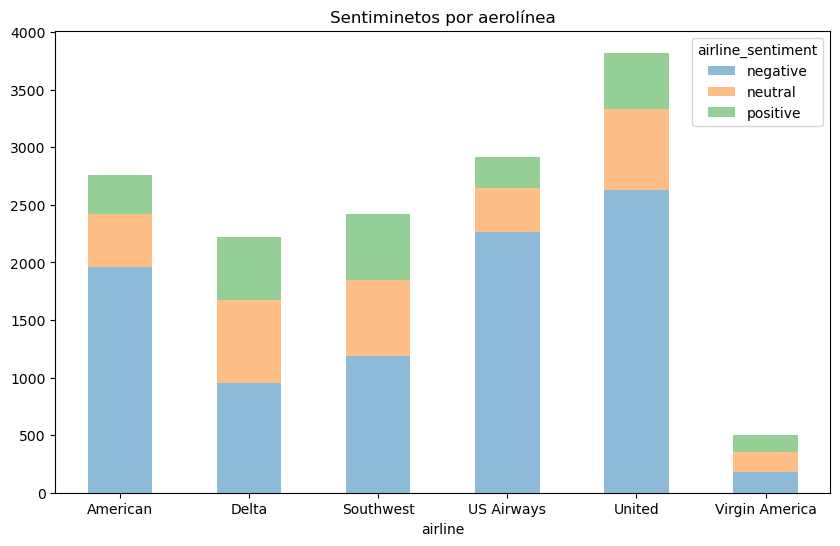

In [7]:
# Plot con cuenta de tweets por cada aerolínea y sentimiento
pd.crosstab(index = tweets["airline"],columns = tweets["airline_sentiment"]).plot(kind='bar',figsize=(10, 6),alpha=0.5,rot=0,stacked=True,title="Sentiminetos por aerolínea")

### Liberias y Variables de interés y predicción

In [9]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import WordNetLemmatizer
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
import nltk
from nltk.tokenize import word_tokenize
from sklearn.model_selection import GridSearchCV
from nltk.corpus import stopwords

In [10]:
# Celda 4
# Descargar recursos de NLTK si no están descargados
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /Users/dfgl43/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /Users/dfgl43/nltk_data...
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/dfgl43/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [11]:
# Separación de variables predictoras (X) y de variable de interés (y)
X = tweets['text']
y = tweets['airline_sentiment'].map({'negative':-1,'neutral':0,'positive':1})

In [14]:
# Separación de datos en set de entrenamiento y test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

### Punto 1 - Uso de CountVectorizer

En la celda 1 creen un modelo de random forest con la libreria sklearn que prediga el sentimiento de los tweets usando los set de entrenamiento y test definidos anteriormente. Usen la función **CountVectorizer** y presenten el desempeño del modelo con la métrica del acurracy.

Recuerden que el preprocesamiento que se haga sobre los datos de entrenamiento  (*.fit_transform()*) deben ser aplicado al set de test (*.transform()*).

In [15]:
# Celda 1
vect_A = CountVectorizer(lowercase=False)
X_train_A = vect_A.fit_transform(X_train)
X_test_A = vect_A.transform(X_test)

In [16]:
vect_A.vocabulary_

{'JetBlue': 3555,
 'of': 10987,
 'course': 7723,
 'am': 6389,
 'AmericanAir': 1555,
 'complt': 7567,
 'incompetence': 9684,
 'on': 11024,
 'flt': 8829,
 '295': 515,
 'Lav': 3765,
 'delay': 7939,
 'from': 8977,
 'pln': 11433,
 'that': 13268,
 'lnded': 10249,
 'last': 10091,
 'nite': 10832,
 'no': 10839,
 'internet': 9814,
 'and': 6422,
 'poor': 11465,
 'svc': 13094,
 'Not': 4296,
 'what': 14069,
 'expect': 8576,
 'SouthwestAir': 5182,
 'Flight': 2892,
 '4968': 860,
 'N8325D': 4161,
 'departs': 7975,
 'MCO': 3899,
 'enroute': 8440,
 'to': 13395,
 'NO_Airport': 4195,
 'http': 9533,
 'co': 7449,
 'fd4SnvKIeM': 8686,
 'USAirways': 5708,
 'does': 8192,
 'anyone': 6472,
 'your': 14308,
 'airline': 6323,
 'know': 10041,
 'how': 9525,
 'do': 8185,
 'their': 13280,
 'job': 9938,
 'united': 13710,
 'Want': 5916,
 'Plane': 4594,
 'dad': 7851,
 'my': 10710,
 'flight': 8797,
 '386': 676,
 'Dallas': 2414,
 'Jacksonville': 3523,
 'fl': 8778,
 'has': 9330,
 'been': 6808,
 'Cancelled': 2094,
 'Flightled

In [17]:
param_grid={'max_depth': [50,100,200],
            'max_features':[None,"sqrt","log2"],
            'n_estimators': [10, 50, 100, 200]}

model = RandomForestClassifier()

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5)
grid_search.fit(X_train_A, y_train)
best_model = grid_search.best_estimator_
best_model

RandomForestClassifier(max_depth=200)

In [18]:
y_pred_rfc = best_model.predict(X_test_A)
accuracy_A = accuracy_score(y_test, y_pred_rfc)
print("Accuracy del model del punto 1:", accuracy_A)

Precisión: 0.7613824503311258


### Punto 2 - Eliminación de Stopwords

En la celda 2 creen un modelo de random forest con la libreria sklearn que prediga el sentimiento de los tweets usando los set de entrenamiento y test definidos anteriormente. Usen la función CountVectorizer, **eliminen stopwords** y presenten el desempeño del modelo con la métrica del acurracy.

Recuerden que el preprocesamiento que se haga sobre los datos de entrenamiento  (*.fit_transform()*) deben ser aplicado al set de test (*.transform()*).

In [20]:
# Celda 2
vect_sw = CountVectorizer(lowercase=False, stop_words='english')
X_train_sw = vect_sw.fit_transform(X_train)
X_test_sw = vect_sw.transform(X_test)

In [21]:
vect_sw.vocabulary_

{'JetBlue': 3555,
 'course': 7665,
 'AmericanAir': 1555,
 'complt': 7512,
 'incompetence': 9568,
 'flt': 8741,
 '295': 515,
 'Lav': 3765,
 'delay': 7879,
 'pln': 11257,
 'lnded': 10122,
 'nite': 10686,
 'internet': 9696,
 'poor': 11289,
 'svc': 12891,
 'Not': 4296,
 'expect': 8494,
 'SouthwestAir': 5182,
 'Flight': 2892,
 '4968': 860,
 'N8325D': 4161,
 'departs': 7915,
 'MCO': 3899,
 'enroute': 8366,
 'NO_Airport': 4195,
 'http': 9420,
 'fd4SnvKIeM': 8604,
 'USAirways': 5708,
 'does': 8129,
 'airline': 6317,
 'know': 9917,
 'job': 9815,
 'united': 13472,
 'Want': 5916,
 'Plane': 4594,
 'dad': 7792,
 'flight': 8709,
 '386': 676,
 'Dallas': 2414,
 'Jacksonville': 3523,
 'fl': 8690,
 'Cancelled': 2094,
 'Flightled': 2912,
 'No': 4271,
 'notified': 10762,
 'What': 5957,
 'going': 9047,
 'trying': 13327,
 'make': 10275,
 'probably': 11426,
 'Late': 3762,
 'did': 7982,
 'email': 8310,
 'Pittsburgh': 4592,
 'International': 3462,
 'look': 10163,
 'forward': 8833,
 'JB': 3495,
 'RT': 4745,
 'b

In [22]:
param_grid={'max_depth': [50,100,200],
            'max_features':[None,"sqrt","log2"],
            'n_estimators': [10, 50, 100, 200]}

model = RandomForestClassifier()

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5)
grid_search.fit(X_train_sw, y_train)
best_model_sw = grid_search.best_estimator_
best_model_sw

RandomForestClassifier(max_depth=200, n_estimators=200)

In [23]:
y_pred_sw = best_model_sw.predict(X_test_sw)
accuracy_sw = accuracy_score(y_test, y_pred_sw)
print("Accuracy del model del punto 2:", accuracy_sw)

Accuracy del model del punto 2: 0.7667632450331126


### Punto 3 - Lematización con verbos

En la celda 3 creen un modelo de random forest con la libreria sklearn que prediga el sentimiento de los tweets usando los set de entrenamiento y test definidos anteriormente. Usen la función CountVectorizer, **lematizen el texto con verbos** y presenten el desempeño del modelo con la métrica del acurracy.

Recuerden que el preprocesamiento que se haga sobre los datos de entrenamiento  (*.fit_transform()*) deben ser aplicado al set de test (*.transform()*).

Lematización
La lemmatización es un proceso en el que se busca el lema de cada palabra de un texto, siendo un lema la forma base o de diccionario de una palabra

In [24]:
# Celda 3
wordnet_lemmatizer = WordNetLemmatizer()

In [25]:
# Definir función de lematización de verbos
class LemmaTokenizer:
    def __init__(self):
        self.wnl = WordNetLemmatizer()
    def __call__(self, doc):
        return [self.wnl.lemmatize(t, pos='v') for t in word_tokenize(doc)]

In [26]:
# Crear un objeto CountVectorizer con lematización de verbos
vectorizer = CountVectorizer(tokenizer=LemmaTokenizer())

In [27]:
# Transformar los datos de entrenamiento y test
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

In [29]:
vectorizer.vocabulary_

{'@': 2453,
 'jetblue': 6836,
 'of': 8206,
 'course': 4347,
 'i': 6443,
 'be': 3311,
 '!': 0,
 '✈️': 11898,
 'americanair': 2860,
 'complt': 4187,
 'incompetence': 6557,
 'on': 8250,
 'flt': 5606,
 '295.lav': 1586,
 'delay': 4599,
 'from': 5777,
 'a': 2481,
 'pln': 8716,
 'that': 10526,
 'lnded': 7260,
 'last': 7087,
 'nite': 8017,
 ',': 63,
 'no': 8026,
 'internet': 6687,
 'and': 2893,
 'poor': 8749,
 'svc': 10330,
 '.': 102,
 'not': 8114,
 'what': 11563,
 'expect': 5306,
 'u': 10918,
 'southwestair': 10036,
 'flight': 5533,
 '4968': 1949,
 '(': 51,
 'n8325d': 7874,
 ')': 52,
 'depart': 4642,
 'mco': 7532,
 'enroute': 5153,
 'to': 10691,
 'no_airport': 8034,
 'http': 6406,
 ':': 2446,
 '//t.co/fd4snvkiem': 397,
 'usairways': 11237,
 'do': 4859,
 'anyone': 2955,
 'your': 11812,
 'airline': 2750,
 'know': 7016,
 'how': 6392,
 'their': 10542,
 'job': 6881,
 '?': 2452,
 'unite': 11112,
 'want': 11483,
 'plane': 8682,
 'dad': 4483,
 'my': 7849,
 '386': 1752,
 'dallas': 4496,
 'jacksonville

In [30]:
# Crear un modelo de Random Forest
rf_model = RandomForestClassifier()

In [32]:
# Definir los parámetros para la búsqueda en la grilla
param_grid={'max_depth': [50,100,200],
            'max_features':[None,"sqrt","log2"],
            'n_estimators': [10, 50, 100, 200]}

In [33]:
# Realizar la búsqueda en la grilla
grid_search = GridSearchCV(rf_model, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_vec, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'max_depth': [50, 100, 200],
                         'max_features': [None, 'sqrt', 'log2'],
                         'n_estimators': [10, 50, 100, 200]},
             scoring='accuracy')

In [34]:
# Obtener el mejor modelo
best_rf_model = grid_search.best_estimator_

In [35]:
# Predecir los datos de test
y_pred = best_rf_model.predict(X_test_vec)

In [36]:
# Calcular el accuracy
accuracylm = accuracy_score(y_test, y_pred)
print("Accuracy del model del punto 3:", accuracylm)

Accuracy del model del punto 3: 0.7760761589403974


### Punto 4 - Multiples técnicas

En la celda 4 creen un modelo de random forest con la libreria sklearn que prediga el sentimiento de los tweets usando los set de entrenamiento y test definidos anteriormente. Usen la función **CountVectorizer, eliminen stopwords, lematizen el texto con verbos** y presenten el desempeño del modelo con la métrica del acurracy.

Recuerden que el preprocesamiento que se haga sobre los datos de entrenamiento  (*.fit_transform()*) deben ser aplicado al set de test (*.transform()*).

In [37]:
# Definir una clase de tokenizador que incluya lematización y eliminación de stopwords
class LemmaTokenizerWithStopwords:
    def __init__(self):
        self.wnl = WordNetLemmatizer()
        self.stop_words = set(stopwords.words('english'))  # Obtener stopwords de NLTK

    def __call__(self, doc):
        # Asegurarse de que solo se procesen palabras alfanuméricas y se excluyan las stopwords
        return [self.wnl.lemmatize(t, pos='v') for t in word_tokenize(doc.lower()) if t not in self.stop_words and t.isalpha()]

# Inicializar el CountVectorizer con el tokenizador personalizado pasando la clase del tokenizador sin instanciar
vectorizer = CountVectorizer(tokenizer=LemmaTokenizerWithStopwords())

# Suponiendo que X_train y X_test ya están definidos y son los conjuntos de datos de texto
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

In [38]:
# Crear un modelo de Random Forest
rf_model = RandomForestClassifier()

In [39]:
# Definir los parámetros para la búsqueda en la grilla
param_grid={'max_depth': [50,100,200],
            'max_features':[None,"sqrt","log2"],
            'n_estimators': [10, 50, 100, 200]}

In [40]:
# Realizar la búsqueda en la grilla
grid_search = GridSearchCV(rf_model, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_vec, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'max_depth': [50, 100, 200],
                         'max_features': [None, 'sqrt', 'log2'],
                         'n_estimators': [10, 50, 100, 200]},
             scoring='accuracy')

In [41]:
# Entrenar el modelo
rf_model.fit(X_train_vec, y_train)

RandomForestClassifier()

In [42]:
# Predecir los datos de test
y_pred = rf_model.predict(X_test_vec)

In [43]:
# Calcular el accuracy
accuracymult = accuracy_score(y_test, y_pred)
print("Accuracy del model del punto 4:", accuracymult)

Accuracy del model del punto 4: 0.7661423841059603


### Punto 5 - Comparación y análisis de resultados

En la celda 5 comparen los resultados obtenidos de los diferentes modelos (random forest) y comenten las ventajas del mejor modelo y las desventajas del modelo con el menor desempeño.

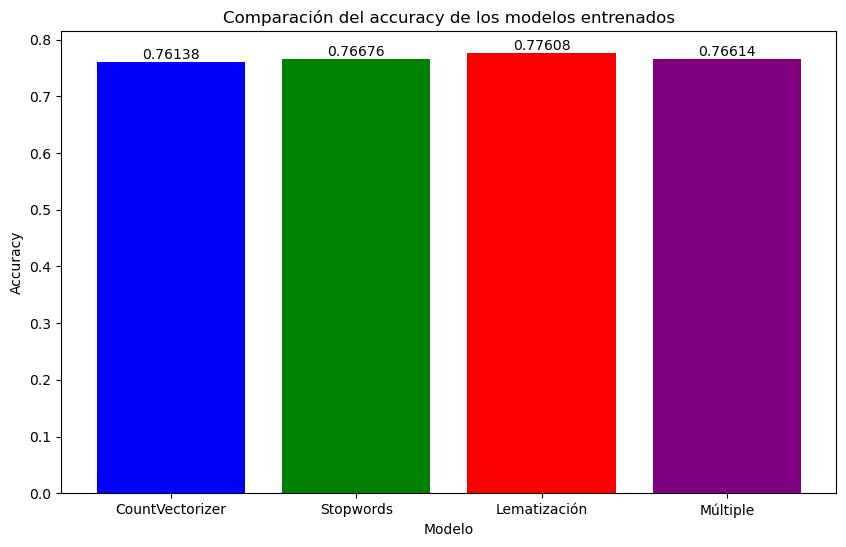

In [45]:
# Celda 5
modelos = ['CountVectorizer', 'Stopwords', 'Lematización', 'Múltiple']
accuracy_valores = [accuracy_A, accuracy_sw, accuracylm, accuracymult]

plt.figure(figsize=(10, 6))
plt.bar(modelos, accuracy_valores, color=['blue', 'green', 'red','purple'])
plt.title('Comparación del accuracy de los modelos entrenados')
plt.xlabel('Modelo')
plt.ylabel('Accuracy')

for i in range(len(accuracy_valores)):
    plt.text(i, accuracy_valores[i], round(accuracy_valores[i], 5), ha='center', va='bottom')
plt.show()

## **Análisis**

Con respecto del accuracy como métrica de evaluación de los modelos, se tiene que el de mejor desempeño, fue el del punto 3 (Lematización con Verbos). Una de las ventajas que encontramos con el uso de este modelo fue el de su tiempo de procesamiento en la parte de la grilla, en donde con los mismos parámetros para el modelo, se obtuvó un menor tiempo. Lo anterior, se puede deber a que en los modelos de lematización se reduce la dimensión del espacio de features. \
Así como para el modelo de lematización se tiene que una ventaja es la reducción del espacio de características, en el modelo del punto 1 (CountVectorizer) que tiene el peor desempeño, el espacio de features es mayor y el tiempo de procesamiento de la grilla fue mayor. \
Un punto adicional a comentar es que antes de entrenar los 4 modelos, esperabamos que el que combinaba las metodologías tendría el mejor desempeño, sin embargo, este no fue el caso. \
En términos generales, se tiene que los resultados de los 4 modelos es muy cercano y ninguno de los modelos se destaca por tener una diferenciación importante. \
Como conclusión final, nos quedamos con que no hay un mejor modelo que se diferencie de entre los demás y se debe aplicar en cada caso las diferentes metodologías.